In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import fashion_mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

print(len(X_train), len(X_valid))

50000 10000


### Create model and train

In [8]:
embedder = tfUMAP(
    training_epochs=20,
    max_sample_repeats_per_epoch=10,
    train_classifier=True,
    valid_X = X_valid,
    valid_Y = Y_valid,
    verbose=True,
)

In [9]:
z = embedder.fit_transform(X_train, y=Y_train)

Construct fuzzy simplicial set
Sun May 31 16:32:09 2020 Finding Nearest Neighbors
Sun May 31 16:32:09 2020 Building RP forest with 16 trees
Sun May 31 16:32:11 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Sun May 31 16:32:24 2020 Finished Nearest Neighbor Search
Sun May 31 16:32:27 2020 Embedding with TensorFlow


Sun May 31 16:38:05 2020 Finished embedding


### look at network architecture

In [10]:
embedder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
z (Dense)                    (None, 2)                 202       
Total params: 98,902
Trainable params: 98,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
embedder.classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
predictions (Dense)          (None, 10)                1010      
Total params: 31,310
Trainable params: 31,310
Non-trainable params: 0
_________________________________________________________________


### Plot model output

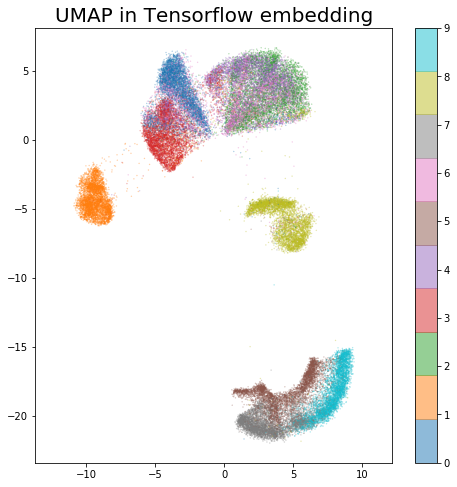

In [12]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### embed test data

In [13]:
z_test = embedder.transform(X_test)

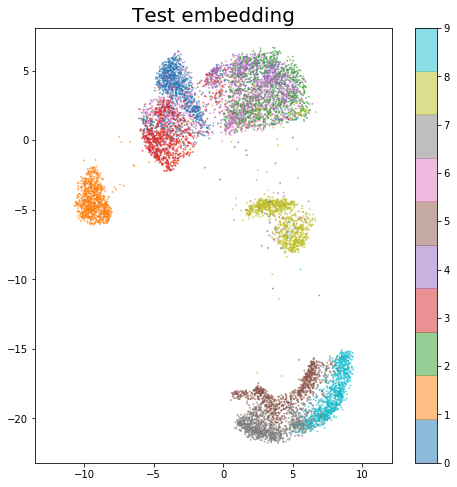

In [14]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_test[:, 0],
    z_test[:, 1],
    c=Y_test.astype(int)[:len(z)],
    cmap="tab10",
    s=1.0,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Test embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [15]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [16]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'classif_loss', 'classif_acc']
['classif_loss', 'classif_acc']


,wall_time,step,val,group,variable
0,1.590968e+09,1,1.857845,train,umap_loss
1,1.590968e+09,2,1.350551,train,umap_loss
2,1.590968e+09,3,1.072400,train,umap_loss


In [17]:
loss_df.variable.unique()

array(['umap_loss', 'classif_loss', 'classif_acc'], dtype=object)

Text(0.5, 1.0, 'Classifier Accuracy')

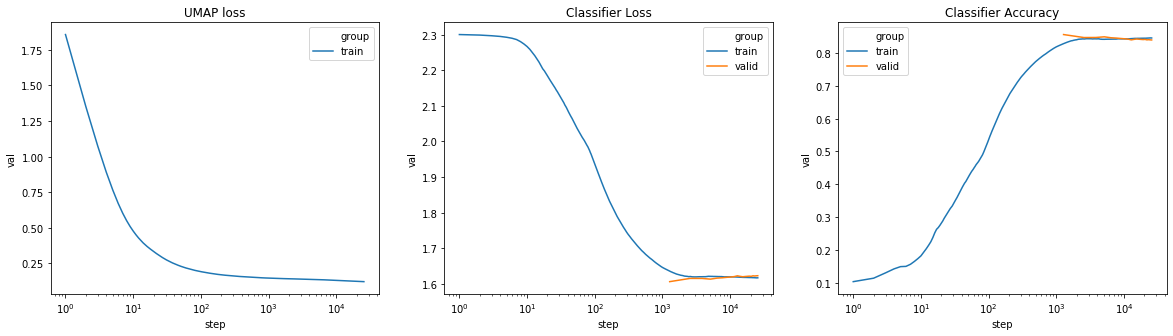

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('Classifier Loss')

ax = axs[2]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_acc'], ax = ax)
ax.set_xscale('log')
ax.set_title('Classifier Accuracy')